In [27]:
from tqdm import tqdm

import os
from dotenv import load_dotenv
from datasets import load_dataset

load_dotenv()
tqdm.pandas()
import pandas as pd
import ast
import re
import torch
import torch.nn.functional as F
from dataset_utils import *
from emotion_tree import get_distance


from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
import yaml
config_path = os.path.join("..", "config.yaml")
# Load the configuration file
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
    EMOTIONS, RANDOM_SEED = (
    config["EMOTIONS"],
    config["RANDOM_SEED"],
)

# Loading Dataset

In [28]:
dataset = load_dataset("go_emotions", "simplified")
dataset.set_format(type="pandas")
df_train = dataset["train"][:]
df_train = df_train.drop(columns=["id"])

int2label = lambda x: dataset["train"].features["labels"].feature.int2str(x)
df_train["labels_text"] = df_train["labels"].apply(int2label)

In [29]:
# samples = df_train[df_train["ds_emotions"].apply(lambda x: "neutral" in x)]
samples = df_train.sample(200, random_state=RANDOM_SEED)

# LLM Labeling

In [30]:
SYSTEM_MESSAGE = "You're an AI expert trained to analyze and categorize emotions present in text. Your goal is to analyze each piece of text according to instructions"

PROMPT_TEMPLATE = f"""
Given: {{comment}}
Emotion list: {EMOTIONS}

Perform an emotional analysis of the comment to by following these steps:

Literal analysis: Identify emotions directly expressed through obvious emotional words/phrases.
Contextual analysis: Consider the full context and implications to detect any additional underlying emotions.
Tonal analysis: Examine tone, subtext, and nuanced emotional cues beyond the literal language.

Only pick one class, if it's not representitive of the text, you may pick up to 2 classes.

For each level of analysis, provide your findings.
Then, summarize by listing the emotion class(es) that apply in <answer> (classes) </answer>.
"""


final_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYSTEM_MESSAGE),
        # few_shot_prompt,
        ("human", PROMPT_TEMPLATE),
    ]
)

In [31]:
providers_api_base = {
    "ollama": "http://localhost:11434/v1",
    # models in https://fireworks.ai/models
    "fireworks": "https://api.fireworks.ai/inference/v1",
    # models in https://console.groq.com/docs/models
    "groq": "https://api.groq.com/openai/v1",
    # models in https://platform.openai.com/docs/models
    "openai": "https://api.openai.com/v1",
}

In [32]:
model_name = "accounts/fireworks/models/llama-v3-70b-instruct"
provider = "fireworks"
TEMPERATURE = 0.5

# Define models
chat = ChatOpenAI(
    temperature=TEMPERATURE,
    model_name=model_name,
    openai_api_base=providers_api_base[provider],
    openai_api_key=os.environ[provider],
)

chain = final_prompt | chat

In [7]:
samples["predictions"] = None
input_tokens = 0
output_tokens = 0
# for index in range(len(samples)):
for index in tqdm(samples.index):
    comment = samples.loc[index]["text"]
    label = samples.loc[index]["labels_text"]
    response = chain.invoke({"comment": comment})
    content = response.content
    input_tokens += response.response_metadata["token_usage"]["prompt_tokens"]
    output_tokens += response.response_metadata["token_usage"]["completion_tokens"]
    extracted_emotions = extract_emotions(content)
    samples.at[index, "predictions"] = extracted_emotions
    samples.at[index, "raw"] = content

input_tokens = input_tokens / len(samples)
output_tokens = output_tokens / len(samples)

100%|██████████| 200/200 [07:50<00:00,  2.35s/it]


In [8]:
samples.to_csv("no_def_preds.csv", index=False)

# Evaluation

In [33]:
samples = pd.read_csv("no_def_preds.csv")

Results for llama-v3-70b-instruct:
Average BCE Loss: 0.8600
Average F1 Score: 0.4676
Average Precision: 0.4779
Average Recall: 0.5331
Average Distance: -0.2089
Total Distance: -41.7730


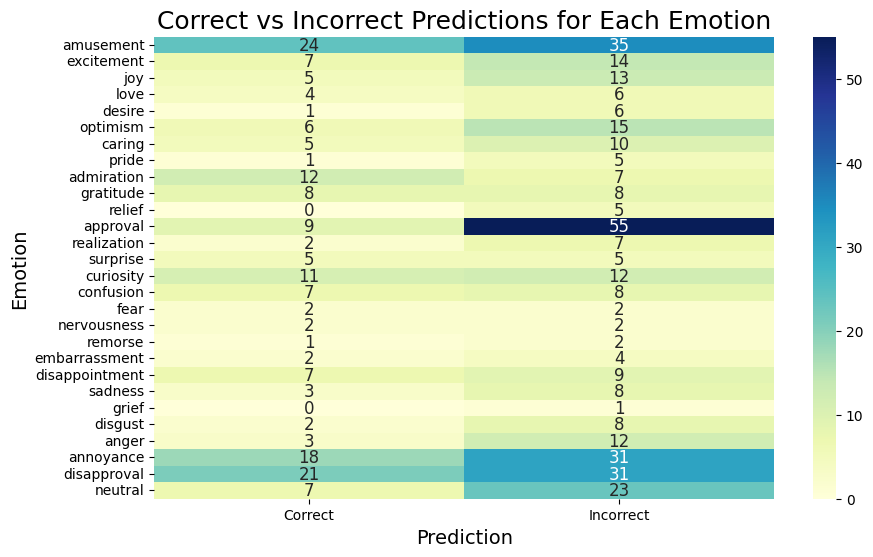

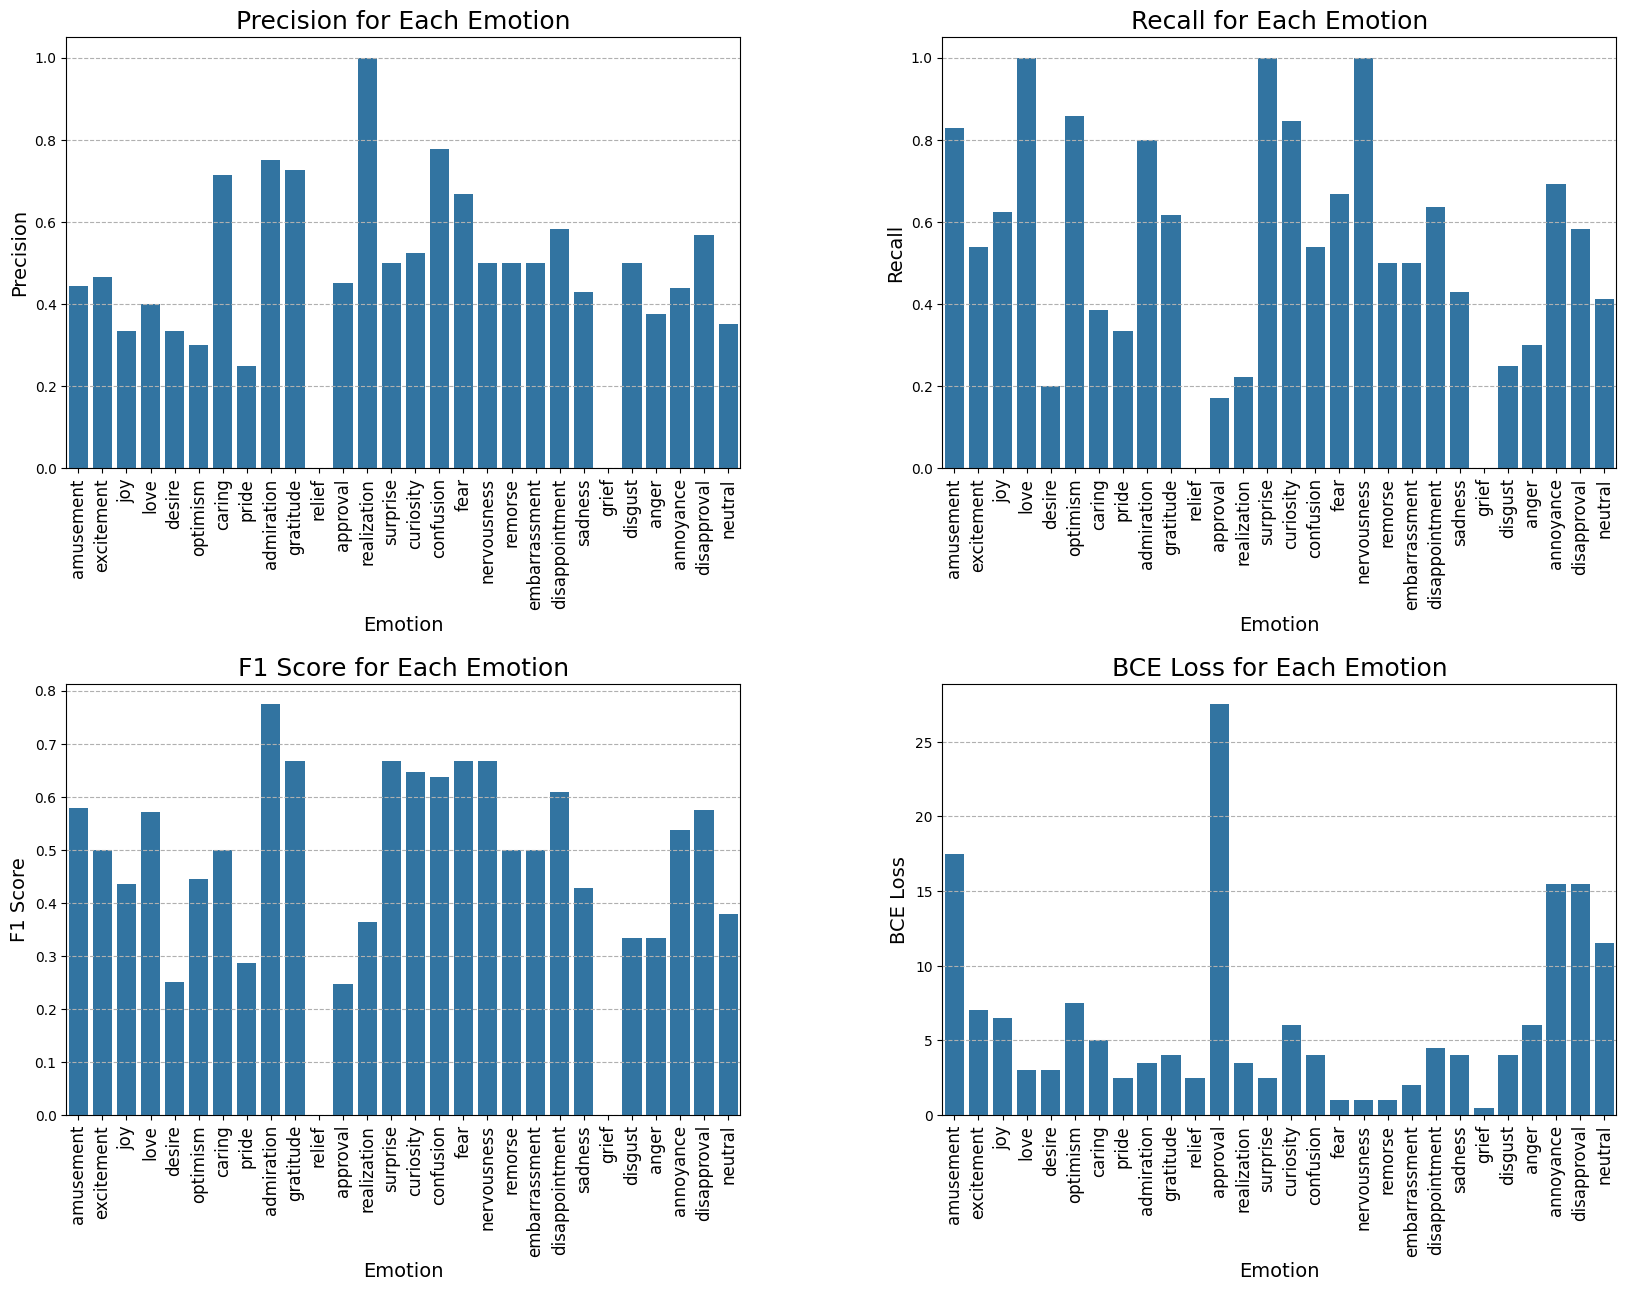

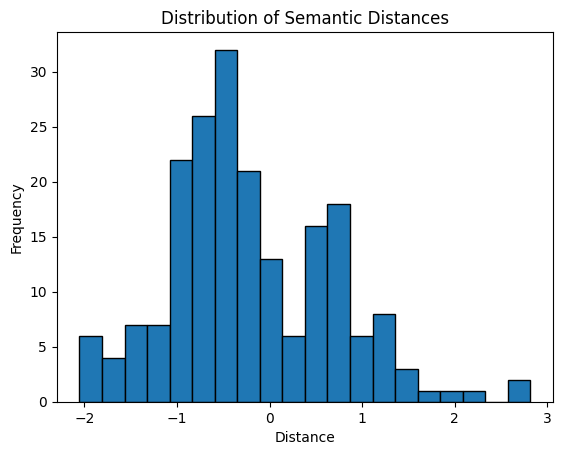

In [35]:
predicted_labels = samples["predictions"]
ground_truth_labels = pd.read_csv("gt.csv", encoding="latin-1")
ground_truth_labels = ground_truth_labels["ground_truth"]
kwargs = {
    # Default Kwargs
    "provider": provider,
    "temperature": TEMPERATURE,
    "avg_input_tokens": 0,
    "avg_output_tokens": 0,
    # Additional Kwargs
    "ensemble": 1,
    "comment": "No definitions included",
}


process_save_results(
    model_name.split("/")[-1],
    SYSTEM_MESSAGE,
    PROMPT_TEMPLATE,
    predicted_labels,
    ground_truth_labels,
    EMOTIONS,
    samples["text"],
    verbose=True,
    ## IMPORTANT ##
    trial_num=2,  # only change this if you're appending to the JSON, otherwise keep it as 0
    ################
    distances_save_name="prediction_distances.csv",
    **kwargs
)

In [25]:
# count the total number of correct in the first trail in the json file
with open("results.json", "r") as f:
    results = json.load(f)
    correct = 0
    incorrect = 0
    scores = results[2]["scores"]  # Access the scores part of the JSON
    for emotion, metrics in scores.items():
        if emotion != "average":  # Skip the average key
            correct += metrics["correct"]
            incorrect += metrics["incorrect"]
    print(f"Correct: {correct}")
    print(f"Incorrect: {incorrect}")

Correct: 108
Incorrect: 353


In [26]:
# count total number of labels in the ground truth csv
total = 0
for label in ground_truth_labels:
    total += len(label.split(","))

print(f"Total: {total}")

Total: 294
